<a href="https://colab.research.google.com/github/spirosChv/imbizo2022/blob/main/exercises/exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating dendrites - Part 1: How inputs propagate to the soma and how inputs interact.

In this notebook we will see how inputs attenuate towards the soma. Also we will see how inputs integrate in a dendritic branch. 

In [1]:
!pip install neuron --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h
from neuron.units import mV, ms, um
h.load_file("stdrun.hoc")

1.0

In [3]:
# @title Make nicer plots -- Execute this cell
def mystyle():
  """
  Create custom plotting style.

  Returns
  -------
  my_style : dict
      Dictionary with matplotlib parameters.

  """
  # color pallette
  style = {
      # Use LaTeX to write all text
      "text.usetex": False,
      "font.family": "DejaVu Sans",
      "font.weight": "bold",
      # Use 16pt font in plots, to match 16pt font in document
      "axes.labelsize": 16,
      "axes.titlesize": 20,
      "font.size": 16,
      # Make the legend/label fonts a little smaller
      "legend.fontsize": 14,
      "xtick.labelsize": 14,
      "ytick.labelsize": 14,
      "axes.linewidth": 2.5,
      "lines.markersize": 10.0,
      "lines.linewidth": 2.5,
      "xtick.major.width": 2.2,
      "ytick.major.width": 2.2,
      "axes.labelweight": "bold",
      "axes.spines.right": False,
      "axes.spines.top": False
  }

  return style


plt.style.use("seaborn-colorblind")
plt.rcParams.update(mystyle())

<ipython-input-3-2e3409f80fae>:39: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


Define the simulation parameters

In [4]:
# Simulation parameters	
tstop = 100 * ms  # simulation time (ms)
h.dt = 0.1 * ms # integration step (ms)
vinit = -65 * mV # initial voltage (mV)

## Create a soma and two dendrites, define their anatomical and biophysical properties and connect them.

In [5]:
soma = h.Section(name='soma')
dend0, dend1 = [h.Section(name=n) for n in ['dend0', 'dend1']]

# Define properties of soma
soma.diam = 20 * um  # diameter (um)
soma.L = 20 * um  # length (um)
soma.Ra = 100  # Axial resistance (Ohm * cm)
soma.cm = 1  # specific membrane capacitance (uF/cm2)   
soma.nseg = 1  # number of segments

# Insert the hh channels (inluding leak)
soma.insert('hh')
for seg in soma: 
  seg.hh.gnabar = 0.12  # Sodium conductance (S/cm2)
  seg.hh.gkbar = 0.036  # Potassium conductance (S/cm2)
  seg.hh.gl = 0.0003  # Leak conductance (S/cm2)
  seg.hh.el = -65  # Reversal potential (mV)

# Define properties of dend0
dend0.diam = 5 * um  # diameter (um)
dend0.L = 500 * um  # length (um)
dend0.cm = 1  # specific membrane capacitance (uF/cm2) 
dend0.Ra = 100  # Axial resistance (Ohm * cm)
dend0.nseg = 11  # number of segments

# Insert passive (leak) channels
dend0.insert('pas')      
for seg in dend0:
  seg.pas.e = -65  # leak reversal potential (mV)
  seg.pas.g = 0.0003  # leak maximal conductance (S/cm2)
	
# Define properties of dend1
dend1.diam = 3 * um  # diameter (um)
dend1.L = 200 * um  # length (um)
dend1.cm = 1  # specific membrane capacitance (uF/cm2)
dend1.Ra = 100  # Axial resistance (Ohm*cm)
dend1.nseg = 13  # number of segments

# Insert passive (leak) channels
dend1.insert('pas')     
for seg in dend1:
  seg.pas.e = -65  # leak reversal potential (mV)
  seg.pas.g = 0.0003  # leak maximal conductance (S/cm2)

Let's connect the compartments!

In [6]:
# Connect the `0` point of `dend0` to the `0` point of the soma, i.e., soma(0)
dend0.connect(soma(0), 0)
# Connect the `1` point of `dend0`, i.e., dend0(1), to the `0` point of the dend1, i.e., dend1(0)
dend1.connect(dend0(1), 0)

dend1

Verify the connections using `h.topology()`

In [7]:
h.topology()


|-|       soma(0-1)
 `----------|       dend0(0-1)
             `------------|       dend1(0-1)



1.0

Plot the shape of neuronal model using the `PlotShape` class. For more info, see [here](https://nrn.readthedocs.io/en/latest/python/visualization/plotshapeclass.html?highlight=PlotShape). The somatic section is represented with a red dot.

In [8]:
ps = h.PlotShape()
ps.plot(plt).mark(soma(0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

## Synaptic Stimulation

In [9]:
# Place the synapse to the middle (0.5) of the soma...
syn = h.ExpSyn(soma(0.5))
syn.e = 0  # Reverse potential of the synapse (mV)

#...create an artificial spike (an "event" to be delivered to the synapse)...
tsignal = 50  # presynaptic spike time
ns = h.NetStim(0.5)  # crete the presynaptic spike
ns.start = tsignal  # set the presynaptic start
ns.number = 1  # set the numbers of spikes

#... and connect the event to the synapse.
nc = h.NetCon(ns, syn)  # create the NetCon object
nc.delay = 0  # set the delay (ms)
nc.weight[0] = 0.008*1  # set the weight

## Example simulation

Calculate and print in terminal the depolarization at the soma and at the middle part of the distal dendrite (`dend1`).

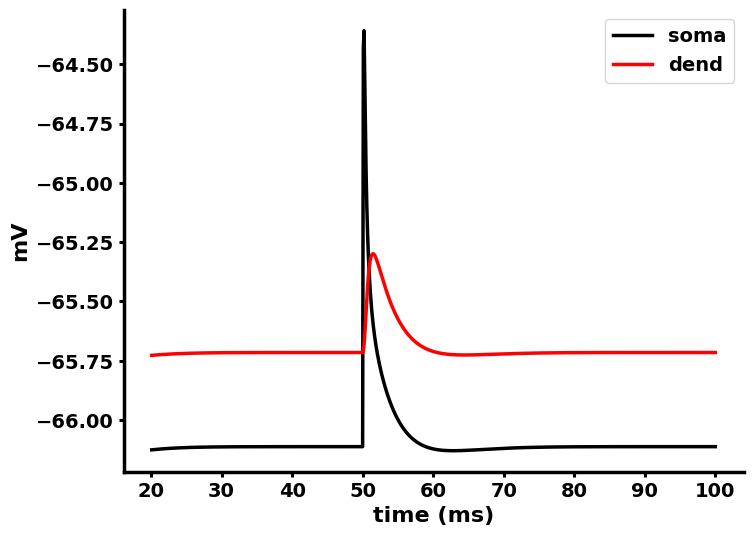


Somatic depolarization is 1.75 mV
Distal Dendritic depolarization is 0.42 mV


In [10]:
vsoma_vec = h.Vector().record(soma(0.5)._ref_v)  # Membrane potential vector
vdend1_vec = h.Vector().record(dend1(0.5)._ref_v)  # Membrane potential vector
t_vec = h.Vector().record(h._ref_t)  # Time stamp vector

# Run the simulation
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20ms to avoid artifacts
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vdend1_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))

plt.figure(figsize=(8, 6))
plt.plot(t_vec, vsoma_vec, color='black', label='soma')
plt.plot(t_vec, vdend1_vec, color='red', label='dend')
plt.xlabel('time (ms)')
plt.ylabel('mV')
plt.legend()
plt.show()

print (f'\nSomatic depolarization is {np.round(vsoma_vec.max()-vsoma_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')
print (f'Distal Dendritic depolarization is {np.round(vdend1_vec.max()-vdend1_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')

### Task 1: How can you easily make this synapse inhibitory?

<details>
<summary>Click to see the answer!</summary>

We have to reduce the reversal potential of the synapse below the resting membrane potential.

```python
syn.e = -70
```

In [11]:
# @markdown Re-execute the code!

e_syn = 0  # @param {type:"number"}
syn.e = e_syn

print(f"The reversal potetnial of the synapse has been set to {e_syn} mV")

The reversal potetnial of the synapse has been set to 0 mV


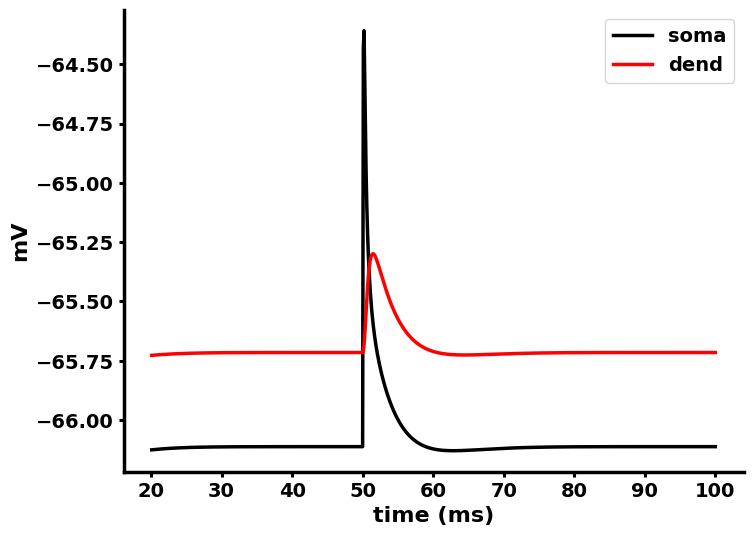

In [12]:
# Run the simulation
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20ms to avoid artifacts
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vdend1_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))

plt.figure(figsize=(8, 6))
plt.plot(t_vec, vsoma_vec, color='black', label='soma')
plt.plot(t_vec, vdend1_vec, color='red', label='dend')
plt.xlabel('time (ms)')
plt.ylabel('mV')
plt.legend()
plt.show()

### Task 2: Move the synapse to the middle of `dend1` section.
### What do you expect for the amplitude and the duration of the EPSP seen at the dendrite and at the soma?

In [14]:
# Place the synapse to the middle of the dend1...
syn = h.ExpSyn(dend1(0.5))
syn.e = 0  # Reverse potential of the synapse (mV)

#... and connect the event to the synapse.
nc = h.NetCon(ns, syn)  # create the NetCon object
nc.delay = 0  # set the delay (ms)
nc.weight[0] = 0.008*1  # set the weight

<details>
<summary>Ckick here to see the answer</summary>

```python
syn = h.ExpSyn(dend1(0.5))
```

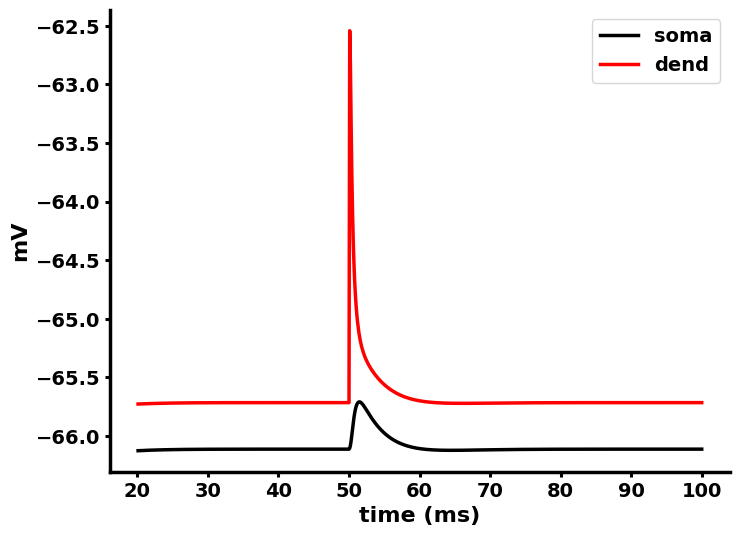


Somatic depolarization is 0.4 mV
Distal Dendritic depolarization is 3.17 mV


In [15]:
# Run the simulation
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20ms to avoid artifacts
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vdend1_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))

plt.figure(figsize=(8, 6))
plt.plot(t_vec, vsoma_vec, color='black', label='soma')
plt.plot(t_vec, vdend1_vec, color='red', label='dend')
plt.xlabel('time (ms)')
plt.ylabel('mV')
plt.legend()
plt.show()

print (f'\nSomatic depolarization is {np.round(vsoma_vec.max()-vsoma_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')
print (f'Distal Dendritic depolarization is {np.round(vdend1_vec.max()-vdend1_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')

### Task 3: Insert 1 to 5 synapses like this one in the same location. In this case, this is equivalent to increasing the weight 1 to 5 times.

- What is the expected (arithmetic sum) versus actual (simulated output)?
- Is their relationship linear? 

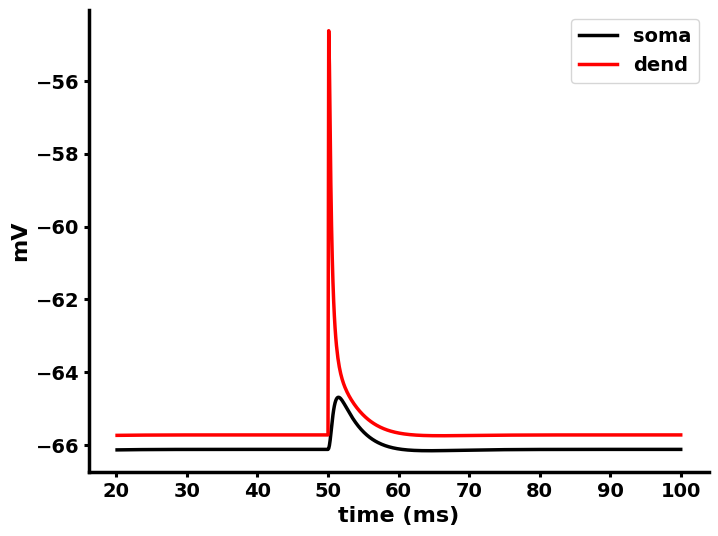


Somatic depolarization is 1.43 mV
Distal Dendritic depolarization is 11.09 mV


In [17]:
nsyn = 4 # @param {type:"slider", min:1, max:25, step:1}
nc.weight[0] = 0.008*nsyn  # set the weight

# Run the simulation
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20ms to avoid artifacts
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vdend1_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))

plt.figure(figsize=(8, 6))
plt.plot(t_vec, vsoma_vec, color='black', label='soma')
plt.plot(t_vec, vdend1_vec, color='red', label='dend')
plt.xlabel('time (ms)')
plt.ylabel('mV')
plt.legend()
plt.show()

print (f'\nSomatic depolarization is {np.round(vsoma_vec.max()-vsoma_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')
print (f'Distal Dendritic depolarization is {np.round(vdend1_vec.max()-vdend1_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')

Now, let's run the loop!

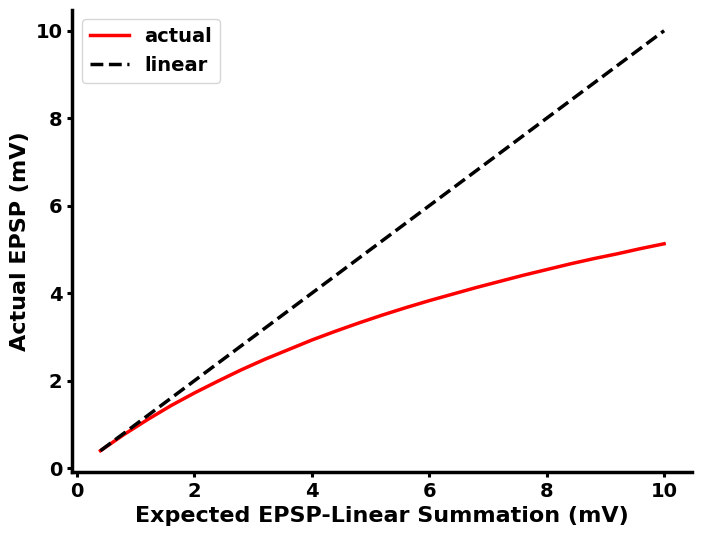

In [18]:
N = 25
actual_epsp = []
for i in range(N):
  nc.weight[0] = 0.008*(i+1)

  # reinitialize the simulator and run again
  h.finitialize(vinit)
  h.continuerun(tstop)
  
  # Remove the first 20ms to avoid artifacts
  tremove = 20
  vsoma_vec.remove(0, int(tremove/h.dt))
  t_vec.remove(0, int(tremove/h.dt))
  actual_epsp.append(np.round(vsoma_vec.max() - vsoma_vec[int((tsignal-tremove)/h.dt)-1], 2))

# Calculate the expected EPSP
expected_epsp = [actual_epsp[0]*i for i in range(1, N+1)]

# Plots the results
plt.figure(figsize=(8, 6)) 
plt.plot(expected_epsp, actual_epsp, color='red', label='actual')
plt.plot(expected_epsp, expected_epsp, linestyle='dashed', color='black', label='linear')
plt.xlabel('Expected EPSP-Linear Summation (mV)')
plt.ylabel('Actual EPSP (mV)')
plt.legend()
plt.show()

## Bonus: Calculate the spatial constant $\lambda$

The space (length) constant $\lambda$ with $\lambda = (R_md/(4R_a))^{1/2}$ is a measure of steady-state voltage decay with distance in a cell. Quantitatively $\lambda$ is the distance over which the steady-state voltage decays to $1/e$ or 37% of its value at the origin in a semi-infinite cable.

**Note:** The units of $\lambda$ are $cm$. How?

\begin{equation}
\lambda = \sqrt{\frac{r_m}{r_a}} = \sqrt{\frac{R_md}{4R_a}} \rightarrow \sqrt{\frac{\Omega \cdot cm^2 \cdot cm}{\Omega \cdot cm}} = cm.
\end{equation}

where $R_a$ is the specific axial resistance (resistivty) in $\Omega \cdot cm$, $R_m$ the specific membrane resistance in $\Omega \cdot cm^2$, and $d$ the diameter in $cm$.

<br>

**Note:** The relationship between $r_m$ (membrane resistance per inverse unit length) and $r_a$ (axial resistance per unit length) with $R_m$ and $R_a$, respectively is:

\begin{align}
r_m &= \frac{R_m}{\pi d} \text{: in } \Omega \cdot cm \\ \\
r_a &= \frac{R_a}{\pi  \left( \frac{d}{2} \right)^2} \text{: in } \Omega \cdot cm^{-1} 
\end{align}

where $\pi  \left( \frac{d}{2} \right)^2$ denotes the corss-section area (i.e, area of a circle with diameter $d$), and $\pi d$ is the length of a membrane (i.e., circle with diameter $d$).

**Remember:** $R_m = 1/g_L$

In [19]:
long_dend = h.Section(name='long_dend')
long_dend.L = 1000
long_dend.diam = 2
long_dend.Ra = 200
long_dend.cm = 1
long_dend.nseg = 13
vdend_vec_segs, vdend_x = [], []
long_dend.insert('pas')
for seg in long_dend:
  seg.pas.e = -65  # leak reversal potential (mV)
  seg.pas.g = 0.0003  # leak maximal conductance (S/cm2)
  vdend_vec_segs.append(h.Vector().record(long_dend(seg.x)._ref_v))  # Membrane potential vector
  vdend_x.append(seg.x)

vdend_vec_segs = [h.Vector().record(long_dend(0)._ref_v)] + vdend_vec_segs + [h.Vector().record(long_dend(1)._ref_v)]
vdend1_x = [0] + vdend_x + [1]

t_vec = h.Vector().record(h._ref_t)  # Time stamp vector

In [20]:
# Add a stimulus at the start of dend1 Section
stim = h.IClamp(long_dend(0))
stim.delay = 30
stim.dur = tstop
stim.amp = 0.1

In [21]:
# reinitialize the simulator and run again
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20ms to avoid artifacts
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vdend_vec_segs = [vec.remove(0, int(tremove/h.dt)) for vec in vdend_vec_segs]
t_vec.remove(0, int(tremove/h.dt))

peak_seg = []
for vec_seg in vdend_vec_segs:
  peak_seg.append(vec_seg.x[-1] - vec_seg.x[0])

In [22]:
# plt.figure(figsize=(8, 6))
# for i, vec in enumerate(vdend1_vec_segs):
#   plt.plot(t_vec, vec-vec.x[0], label=f"segment {i}")
# plt.xlabel('time (ms)')
# plt.ylabel('$\Delta V$ (mV)')
# plt.legend()
# plt.show()

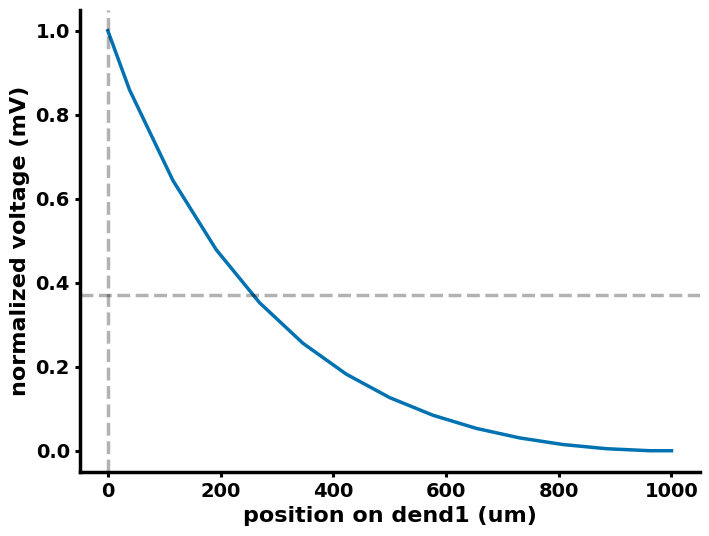

In [23]:
physical_dists = [0] + [long_dend.L*(0.5 + i)/long_dend.nseg for i in range(long_dend.nseg)] + [long_dend.L]
norm_voltage = [(p-min(peak_seg))/(max(peak_seg)-min(peak_seg)) for p in peak_seg]

plt.figure(figsize=(8, 6))
plt.plot(physical_dists, norm_voltage)
plt.axvline(x=0*dend1.L, linestyle='dashed', color='k', alpha=0.3)
plt.axhline(y=0.37, linestyle='dashed', color='k', alpha=0.3)
plt.xlabel('position on dend1 (um)')
plt.ylabel('normalized voltage (mV)')
plt.show()

In [24]:
idx = np.where(np.isclose(norm_voltage, 1/np.exp(1), atol=1e-1))[0][-1].item()
print(f"The spatial constant is: {physical_dists[idx]} um")

The spatial constant is: 269.2307692307692 um


We can plot the voltage across space using the `h.RangeVarPlot()` function. Notice that, this function plots the voltage of all segments between two specific nodes at the end of the simulation.

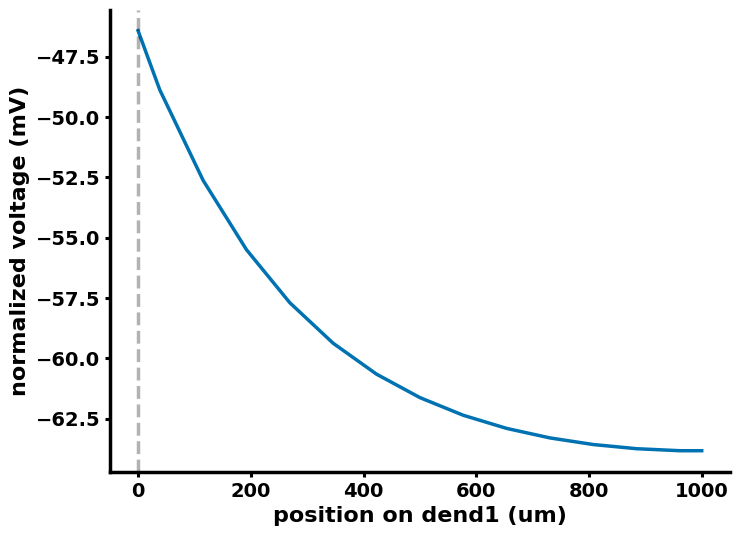

In [25]:
rvp = h.RangeVarPlot('v', long_dend(0), long_dend(1))
plt.figure(figsize=(8, 6))
rvp.plot(plt)
plt.axvline(x=0*long_dend.L, linestyle='dashed', color='k', alpha=0.3)
plt.xlabel('position on dend1 (um)')
plt.ylabel('normalized voltage (mV)')
plt.show()
plt.show()

We can use the `curve_fit` method from `scipy` package. For more info see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

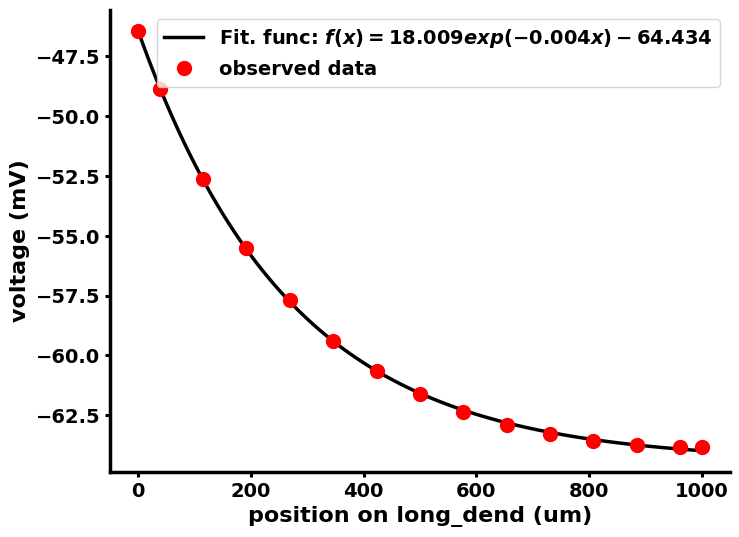

In [26]:
from scipy.optimize import curve_fit

voltage = np.array(rvp.vector())

# define type of function to search
def model_func(vector, a, b, c):
  return a * np.exp(-b*vector) + c


# curve fit
p0 = (1., 1.e-5, 1.)  # initial guess of params
opt, pcov = curve_fit(model_func, physical_dists, voltage, p0)
a, b, c = opt

xfitted = np.linspace(0, long_dend.L, 100)
yfitted = model_func(xfitted, a, b, c)

plt.figure(figsize=(8, 6))
plt.plot(xfitted, yfitted, color='black', label=f"Fit. func: $f(x) = {a:.3f} exp(- {b:.3f} x) {c:.3f}$")
plt.plot(physical_dists, voltage, 'ro', label='observed data')
plt.xlabel('position on long_dend (um)')
plt.ylabel('voltage (mV)')
plt.legend()
plt.show()

In [27]:
print(f"The spatial constant is: {1/b} um")

The spatial constant is: 271.50531219696074 um


In [28]:
Rm = 1/long_dend(0.5).pas.g  # Membrane resistance in Ohm cm2
lambda_x = np.sqrt(long_dend.diam*(1e-4)*Rm/(4*long_dend.Ra))
print(f"The theoretical spatial constant is: {lambda_x*1e4} um")

The theoretical spatial constant is: 288.6751345948129 um


### Questions:

1. How we can reduce/increase the space constant?

2. How dendrites overcome the limitation of the attenuated signals?